## Campaign Response Modelling

This next section will centralize around finding effective marketing strategies for specific customer subsets. In this section, we will explore what features are important in modelling the likelihood that a customer will respond to campaigns.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def load(file_path):
    return pd.read_csv(file_path)

data = load('marketing_data_post_rfm.csv')

### Baseline Model

In [2]:
def get_campaign_features(df):
    df['Campaign_Response_Rate'] = df['Total_Campaign_Accepted'] / 5

    # Channel preferences
    df['Prefers_Web'] = (df['NumWebPurchases'] > df[['NumCatalogPurchases', 'NumStorePurchases']].max(axis=1)).astype(int)
    df['Prefers_Store'] = (df['NumStorePurchases'] > df[['NumCatalogPurchases', 'NumWebPurchases']].max(axis=1)).astype(int)
    df['Deal_Seeker'] = (df['NumDealsPurchases'] / df['Total_Purchases'] > 0.3).astype(int)
    
    return df

def encode_segments(df):
    df_encoded = pd.get_dummies(df, columns=['Customer_Persona'], prefix='segment')
    return df_encoded

data = get_campaign_features(data)
# data = encode_segments(data)

In [3]:
data

,Unnamed: 0,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntMeatProducts_Pct,MntFishProducts_Pct,MntSweetProducts_Pct,MntGoldProds_Pct,Primary_Product,Customer_Persona,Campaign_Response_Rate,Prefers_Web,Prefers_Store,Deal_Seeker
0,0,1826,1970,Graduation,84835.0,0,0,2014-06-16,0,189,...,0.318487,0.093277,0.158824,0.183193,MntMeatProducts,Big Spenders,0.0,0,1,0
1,1,1,1961,Graduation,57091.0,0,0,2014-06-15,0,464,...,0.110919,0.012132,0.000000,0.064125,MntWines,Loyal Customers,0.2,0,0,0
2,2,10476,1958,Graduation,67267.0,0,1,2014-05-13,0,134,...,0.235060,0.059761,0.007968,0.119522,MntWines,New Customers,0.0,0,1,0
3,3,1386,1967,Graduation,32474.0,1,1,2014-05-11,0,10,...,0.090909,0.000000,0.000000,0.000000,MntWines,New Customers,0.0,0,1,0
4,4,5371,1989,Graduation,21474.0,1,0,2014-04-08,0,6,...,0.263736,0.120879,0.000000,0.373626,MntGoldProds,New Customers,0.2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,2235,10142,1976,PhD,66476.0,0,1,2013-03-07,99,372,...,0.182874,0.068215,0.069666,0.113208,MntWines,At Risk,0.0,0,1,0
2232,2236,5263,1977,2n Cycle,31056.0,1,0,2013-01-22,99,5,...,0.236364,0.054545,0.145455,0.290909,MntGoldProds,Potential Loyalists,0.0,0,1,0
2233,2237,22,1976,Graduation,46310.0,1,0,2012-12-03,99,185,...,0.284790,0.048544,0.016181,0.045307,MntWines,At Risk,0.0,1,0,0
2234,2238,528,1978,Graduation,65819.0,0,0,2012-11-29,99,267,...,0.506869,0.107737,0.119306,0.045553,MntMeatProducts,At Risk,0.0,0,1,0


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features for campaign response
campaign_features = ['Age', 'Income', 'Total_Children', 'Education_Numeric', 
                    'R_Score', 'F_Score', 'M_Score', 'Primary_Product',
                    'Prefers_Web', 'Deal_Seeker', 'NumWebVisitsMonth', 
                    'MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                    'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Marital_Widow', 
                    'Country_AUS', 'Country_CA', 'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA', 
                    'Country_SP', 'Country_US', 'Customer_Persona'
                    # 'segment_At Risk', 'segment_Big Spenders','segment_Champions', 'segment_Loyal Customers', 'segment_New Customers', 'segment_Potential Loyalists', 
                    # 'segment_Price Sensitive'
                    ]

# Target: Overall campaign responsiveness
X = data[campaign_features]
y = (data['Total_Campaign_Accepted'] > 0).astype(int)

# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[('Primary_Product_ohe', OneHotEncoder(handle_unknown='ignore'), ['Primary_Product']),
                  ('segment_ohe', OneHotEncoder(handle_unknown='ignore'), ['Customer_Persona'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

/home/ccaban/miniforge3/envs/essentia/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Primary_Product_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Primary_Product']),
                                                 ('segment_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Customer_Persona'])])),
                ('model', RandomForestClassifier(random_state=42))])

Classification Report

Accuracy: 88.17%
Precision: 86.00%
Recall: 48.31%
F1 Score: 61.87%
AUC Score: 88.82%

Current Overall Response Rate: 0.207


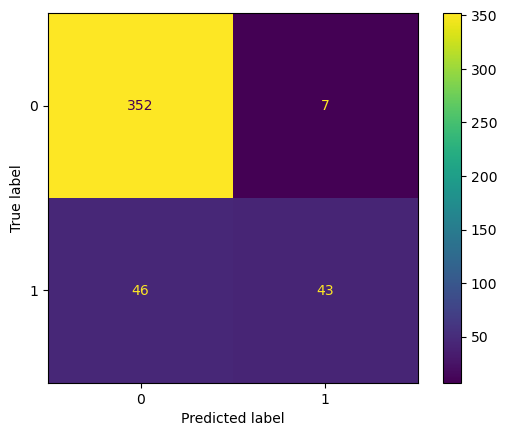

In [5]:
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, f1_score

# Formatting options for print statements
bold_underline = "\033[1;4m"
reset_format = "\033[0m"

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print(f"{bold_underline}Classification Report{reset_format}\n")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel().tolist()

print(f"Accuracy: {(((tp + tn) / len(y_pred)) * 100):.2f}%")
print(f"Precision: {(((tp) / (tp + fp)) * 100):.2f}%")
print(f"Recall: {(((tp) / (tp + fn)) * 100):.2f}%")
print(f"F1 Score: {(f1_score(y_test, y_pred) * 100):.2f}%")
print(f"AUC Score: {(roc_auc_score(y_test, y_pred_proba) * 100):.2f}%\n")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

current_response_rate = y.mean()
print(f"{bold_underline[:3]}mCurrent Overall Response Rate{reset_format}: {current_response_rate:.3f}")

Based on the metrics observed above, we can see that the current marketting strategies aren't effective for customer responsiveness. The baseline model that we are able to predict customer responsiveness with ~89% accuracy, evidenced by the AUC score and Accuracy metrics. 

The confusion matrix reinforces that majority of customers aren't responsive to our campaigns (the top row represents the true 0 class / *Not responsive*) and establishes that this model is very good at identifying people who won't respond (high TN). However, it does miss on many people who would respond (high FN), so the recall is low. Conversely, the FP labels are minimal but represent customers that were labeled as "Responsive" but are in fact "Not Responsive" customers, which could lead to wasted funds/effort if this model was deployed. Therefore, future iterations of this model may be tuned to address one of the two situations:

1) If cost of contacting non-responders is high, then we would want to prioritize our precision. Ideally, we would want to minimize the amount of observed FP even further.
2) If missing out on potential responders deserves greater emphasis, then we would want to prioritize the recall. This means that would want to minimize the amount of FN so we can more accurately capture positive cases (Responders).

### Improvement to the model: SMOTE

Based on the previous model, we were able to recognize that the classes were a bit imbalanced and were likely sampling more of class 0 than class 1. Therefore, a slight design change can be using oversampling to combat this under-representation of the data.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC


# Features for campaign response

numerical_features = ['Age', 'Income', 'Total_Children', 'Education_Numeric',
                     'R_Score', 'F_Score', 'M_Score', 'NumWebVisitsMonth',
                     'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                     'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                     'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                     'Prefers_Web', 'Deal_Seeker', 'Marital_Divorced', 'Marital_Married', 
                     'Marital_Single', 'Marital_Together', 'Marital_Widow', 
                     'Country_AUS', 'Country_CA', 'Country_GER', 'Country_IND', 
                     'Country_ME', 'Country_SA', 'Country_SP', 'Country_US']

categorical_features = ['Primary_Product', 'Customer_Persona']

# Preserve column order
all_columns = numerical_features + categorical_features
X_train_ordered = X_train[all_columns].copy()

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train_ordered[col] = le.fit_transform(X_train_ordered[col])
    label_encoders[col] = le

# Scale numerical features (this maintains DataFrame structure)
scaler = StandardScaler()
X_train_ordered[numerical_features] = scaler.fit_transform(X_train_ordered[numerical_features])

# Get integer indices for categorical features
categorical_indices = [all_columns.index(col) for col in categorical_features]
print(f"Categorical indices: {categorical_indices}")  # Should print something like [34, 35]

# Apply SMOTENC with integer indices
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)

# This should work now - pass the DataFrame values as array
X_resampled, y_resampled = smotenc.fit_resample(X_train_ordered.values, y_train)

# Convert back to DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=all_columns)

# Decode categorical features
for col in categorical_features:
    X_resampled_df[col] = label_encoders[col].inverse_transform(
        X_resampled_df[col].astype(int)
    )

# One-hot encode
X_train_final = pd.get_dummies(X_resampled_df, columns=categorical_features)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_resampled)

Categorical indices: [33, 34]


RandomForestClassifier(random_state=42)

In [7]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.over_sampling import SMOTENC


# # Features for campaign response
# campaign_features = ['Age', 'Income', 'Total_Children', 'Education_Numeric', 
#                     'R_Score', 'F_Score', 'M_Score', 'Primary_Product',
#                     'Prefers_Web', 'Deal_Seeker', 'NumWebVisitsMonth', 
#                     'MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
#                     'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#                     'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Marital_Widow', 
#                     'Country_AUS', 'Country_CA', 'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA', 
#                     'Country_SP', 'Country_US', 'Customer_Persona']

# # Target: Overall campaign responsiveness
# X = data[campaign_features]
# y = (data['Total_Campaign_Accepted'] > 0).astype(int)

# # Train model
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# preprocessor = ColumnTransformer(
#     transformers=[('Primary_Product_ohe', OneHotEncoder(handle_unknown='ignore'), ['Primary_Product'])
#                   ('segment_ohe', OneHotEncoder(handle_unknown='ignore'), ['Customer_Persona'])
#     ],
#     remainder='passthrough'
# )

# pipeline = ImbPipeline([
#     ('preprocessing', preprocessor),
#     ('oversample', SMOTE(random_state=42)),
#     ('model', RandomForestClassifier(n_estimators=100, random_state=42))
# ])

# pipeline.fit(X_train, y_train)

In [8]:
X_test_ordered = X_test[all_columns].copy()

# Apply same scaling to numerical features
X_test_ordered[numerical_features] = scaler.transform(X_test_ordered[numerical_features])

# Revert label encoding and apply get_dummies on original category values:
for col in categorical_features:
    le = label_encoders[col]
    X_test_ordered[col] = X_test_ordered[col].map(lambda x: x if x in le.classes_ else 'Unknown')

X_test_final = pd.get_dummies(X_test_ordered, columns=categorical_features)

# missing_cols = set(X_train_final.columns) - set(X_test_final.columns)
# for col in missing_cols:
#     X_test_final[col] = 0

# Remove extra columns in test set
# extra_cols = set(X_test_final.columns) - set(X_train_final.columns)
# X_test_final = X_test_final.drop(columns=extra_cols)

# Reorder columns to match training data
# X_test_final = X_test_final[X_train_final.columns]

In [9]:
X_test_final.columns

Index(['Age', 'Income', 'Total_Children', 'Education_Numeric', 'R_Score',
       'F_Score', 'M_Score', 'NumWebVisitsMonth', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'Prefers_Web',
       'Deal_Seeker', 'Marital_Divorced', 'Marital_Married', 'Marital_Single',
       'Marital_Together', 'Marital_Widow', 'Country_AUS', 'Country_CA',
       'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA', 'Country_SP',
       'Country_US', 'Primary_Product_MntFishProducts',
       'Primary_Product_MntFruits', 'Primary_Product_MntGoldProds',
       'Primary_Product_MntMeatProducts', 'Primary_Product_MntSweetProducts',
       'Primary_Product_MntWines', 'Customer_Persona_At Risk',
       'Customer_Persona_Big Spenders', 'Customer_Persona_Champions',
       'Customer_Persona_Loyal Customers', 'Customer_Persona_New Customers',
       'Custom

Classification Report

Accuracy: 86.61%
Precision: 68.35%
Recall: 60.67%
F1 Score: 64.29%
AUC Score: 89.50%

Current Overall Response Rate: 0.207


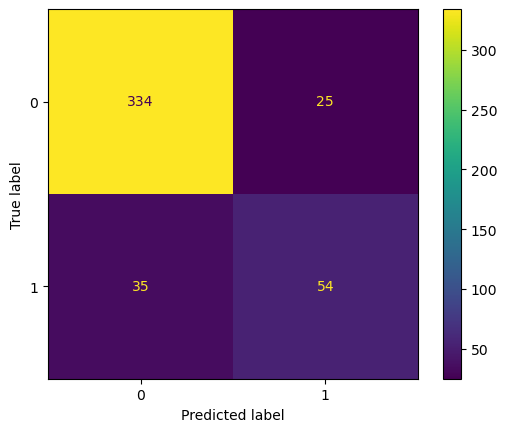

In [10]:
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, f1_score

# Formatting options for print statements
bold_underline = "\033[1;4m"
reset_format = "\033[0m"

y_pred = rf_model.predict(X_test_final)
y_pred_proba = rf_model.predict_proba(X_test_final)[:, 1]

print(f"{bold_underline}Classification Report{reset_format}\n")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel().tolist()

print(f"Accuracy: {(((tp + tn) / len(y_pred)) * 100):.2f}%")
print(f"Precision: {(((tp) / (tp + fp)) * 100):.2f}%")
print(f"Recall: {(((tp) / (tp + fn)) * 100):.2f}%")
print(f"F1 Score: {(f1_score(y_test, y_pred) * 100):.2f}%")
print(f"AUC Score: {(roc_auc_score(y_test, y_pred_proba) * 100):.2f}%\n")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

current_response_rate = y.mean()
print(f"{bold_underline[:3]}mCurrent Overall Response Rate{reset_format}: {current_response_rate:.3f}")

### Improvement to the model: Comparing Models

In [11]:
from smotenc_gridsearch import *

# Define parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    },
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],  # liblinear supports both l1 and l2
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2],
        'scale_pos_weight': [(y_train == 0).sum() / (y_train == 1).sum()]  # For imbalance
    }
}

# Define models
base_models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train and tune models
best_models = {}
for name, model in base_models.items():
    print(f"\nTuning {name}...")
    
    # Create custom GridSearchCV
    grid_search = SMOTENCGridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Make predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    # Print results
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.2f}")
    
    best_models[name] = grid_search


Tuning RandomForest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       359
           1       0.76      0.61      0.68        89

    accuracy                           0.88       448
   macro avg       0.83      0.78      0.80       448
weighted avg       0.88      0.88      0.88       448

AUC Score: 0.90

Tuning LogisticRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
              precision    recall  f1-score   support

           0       0.93      0.74      0.82       359
           1       0.42      0.79      0.55        89

    accuracy                           0.75       448
   macro avg       0.68      0.76      0.69       448
weighted avg       0.83      0.75      0.77       448

AUC Score: 0.84

Tuning XGBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
              precision    recall  f1-score   support

    

Despite comparing numerous models with different hyperparameter sets, we are going to move on with the SMOTE Random Forest since it provides a good balance of the F1 score, offers greater precision in exchange for dips in the recall, and preserves the interpretability from using a Random Forest model. In the next section, we will be understanding the top features lists and breakdown customer segments by predicted response probability.

## Feature Importance

To start, we are going to re-initialize the SMOTE model and utilize it as the best model moving forward.

In [12]:
# # Features for campaign response
# campaign_features = ['Age', 'Income', 'Total_Children', 'Education_Numeric', 
#                     'R_Score', 'F_Score', 'M_Score', 'Primary_Product',
#                     'Prefers_Web', 'Deal_Seeker', 'NumWebVisitsMonth', 
#                     'MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
#                     'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#                     'Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Marital_Widow', 
#                     'Country_AUS', 'Country_CA', 'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA', 
#                     'Country_SP', 'Country_US']

# # Target: Overall campaign responsiveness
# X = data[campaign_features]
# y = (data['Total_Campaign_Accepted'] > 0).astype(int)

# # Train model
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# preprocessor = ColumnTransformer(
#     transformers=[('Primary_Product_ohe', OneHotEncoder(handle_unknown='ignore'), ['Primary_Product'])
#     ],
#     remainder='passthrough', force_int_remainder_cols=False
# )

# best_model = ImbPipeline([
#     ('preprocessing', preprocessor),
#     ('oversample', SMOTE(random_state=42)),
#     ('model', RandomForestClassifier(n_estimators=100, random_state=42))
# ])

# best_model.fit(X_train, y_train)

In [13]:
X_test_final.columns

Index(['Age', 'Income', 'Total_Children', 'Education_Numeric', 'R_Score',
       'F_Score', 'M_Score', 'NumWebVisitsMonth', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'Prefers_Web',
       'Deal_Seeker', 'Marital_Divorced', 'Marital_Married', 'Marital_Single',
       'Marital_Together', 'Marital_Widow', 'Country_AUS', 'Country_CA',
       'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA', 'Country_SP',
       'Country_US', 'Primary_Product_MntFishProducts',
       'Primary_Product_MntFruits', 'Primary_Product_MntGoldProds',
       'Primary_Product_MntMeatProducts', 'Primary_Product_MntSweetProducts',
       'Primary_Product_MntWines', 'Customer_Persona_At Risk',
       'Customer_Persona_Big Spenders', 'Customer_Persona_Champions',
       'Customer_Persona_Loyal Customers', 'Customer_Persona_New Customers',
       'Custom

/home/ccaban/miniforge3/envs/essentia/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


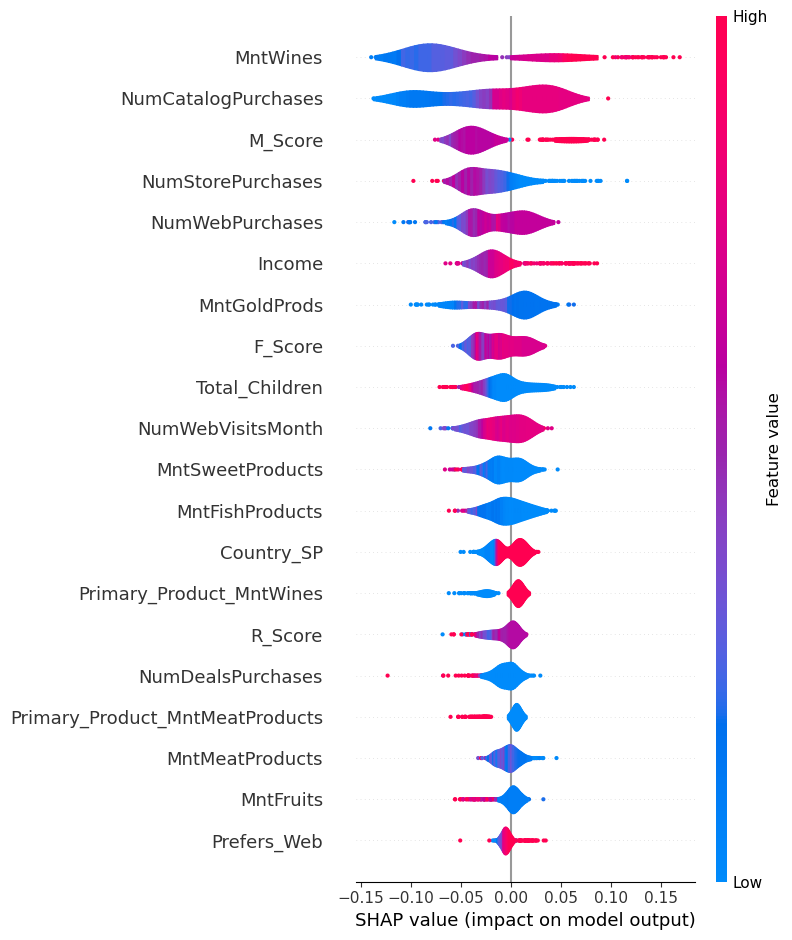

In [14]:
import shap
import numpy as np

# Choose the model name you want SHAP values for
model_name = 'RandomForest'  # or 'XGBoost', 'LogisticRegression'
best_grid_search = best_models[model_name]

# Extract the best estimator (final fitted model)
best_model = best_models['RandomForest'].best_estimator_

# If you used preprocessing (e.g., ColumnTransformer), transform X_test first
# Assuming X_test is already preprocessed or no preprocessor was used
X_test_array = np.array(X_test_final).astype(np.float64)

# Select appropriate explainer
if model_name == 'RandomForest':
    explainer = shap.TreeExplainer(best_model)
elif model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
elif model_name == 'LogisticRegression':
    explainer = shap.LinearExplainer(best_model, X_test_array, feature_perturbation="interventional")

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_array)

# Plot (example: summary plot)
shap.summary_plot(shap_values[:,:,1], X_test_array, feature_names=X_test_final.columns, plot_type='violin')

**Provide discussion about plot**

In [15]:
data.Customer_Persona.unique().tolist()

['Big Spenders',
 'Loyal Customers',
 'New Customers',
 'Champions',
 'Potential Loyalists',
 'Price Sensitive',
 'At Risk']

In [16]:
X_test_final[X_test_final['Customer_Persona_Champions'] == 1]

,Age,Income,Total_Children,Education_Numeric,R_Score,F_Score,M_Score,NumWebVisitsMonth,MntWines,MntFruits,...,Primary_Product_MntMeatProducts,Primary_Product_MntSweetProducts,Primary_Product_MntWines,Customer_Persona_At Risk,Customer_Persona_Big Spenders,Customer_Persona_Champions,Customer_Persona_Loyal Customers,Customer_Persona_New Customers,Customer_Persona_Potential Loyalists,Customer_Persona_Price Sensitive
100,1.787501,0.397855,0.068385,1.536301,1.420765,1.401940,0.714363,0.282374,0.580229,-0.185117,...,False,False,True,False,False,True,False,False,False,False
298,-0.587106,0.484562,0.068385,-0.466547,1.420765,1.401940,0.714363,0.282374,0.990064,-0.483776,...,False,False,True,False,False,True,False,False,False,False
485,1.957116,0.706988,-1.275263,0.534877,0.712956,1.401940,0.714363,-1.393592,0.928146,-0.010899,...,False,False,True,False,False,True,False,False,False,False
482,-0.247877,1.144900,0.068385,0.534877,0.712956,1.401940,0.714363,-0.974601,0.630353,0.586420,...,False,False,True,False,False,True,False,False,False,False
353,-0.417491,1.466892,-1.275263,-0.466547,1.420765,1.401940,1.414242,-1.393592,1.391053,0.213095,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1.193849,0.725159,0.068385,-0.466547,1.420765,1.401940,0.714363,-0.136617,0.028869,0.213095,...,True,False,False,False,False,True,False,False,False,False
416,-1.519988,1.383773,-1.275263,-0.466547,1.420765,1.401940,0.714363,-1.812584,-0.419295,-0.085564,...,True,False,False,False,False,True,False,False,False,False
610,0.006546,0.522813,0.068385,-0.466547,0.712956,0.701558,1.414242,-0.555609,0.600868,2.652147,...,False,False,True,False,False,True,False,False,False,False
423,0.176160,0.255100,-1.275263,-0.466547,1.420765,0.701558,1.414242,0.282374,-0.112656,2.826365,...,True,False,False,False,False,True,False,False,False,False


In [17]:
personas = ['Customer_Persona_Champions', 'Customer_Persona_Loyal Customers', 'Customer_Persona_New Customers', 'Customer_Persona_Potential Loyalists', 'Customer_Persona_At Risk']

personas_shaps = {}

for persona in personas:

    persona_mask = X_test_final[persona] == 1
    X_test_persona = X_test_final[persona_mask]

    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_persona)
    personas_shaps[persona] = {
            'shap_values': shap_values,
            'X_transformed': X_test_persona,
            'sample_count': len(X_test_persona),
            'name': persona
        }

Showing SHAP summary for: Customer_Persona_Champions with length of 64
Persona Shap shape: (64, 46)
X_transformed shape: (64, 46)


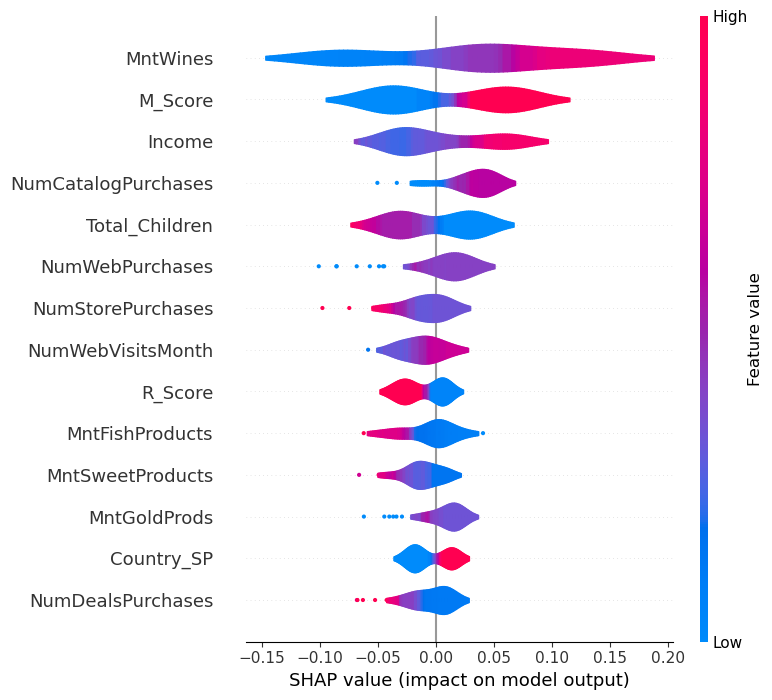

Showing SHAP summary for: Customer_Persona_Loyal Customers with length of 52
Persona Shap shape: (52, 46)
X_transformed shape: (52, 46)


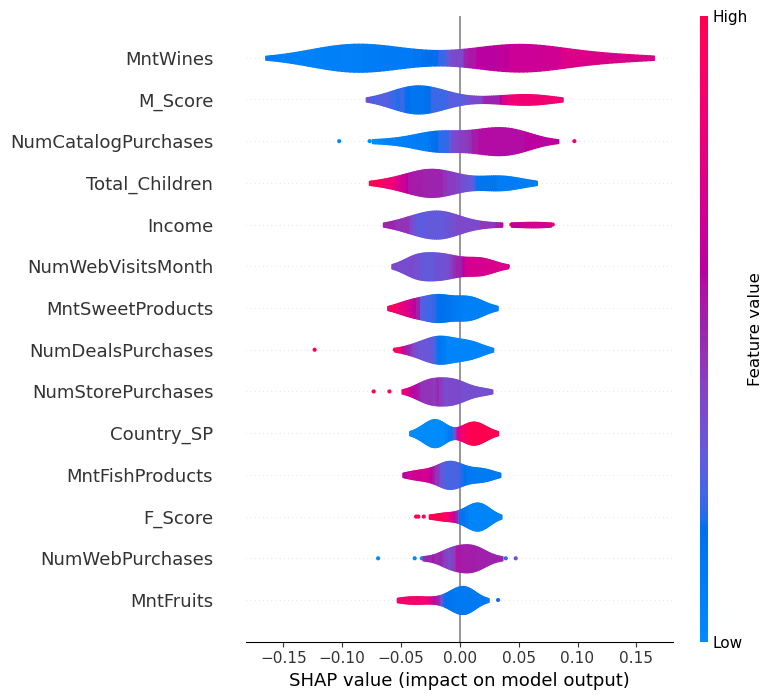

Showing SHAP summary for: Customer_Persona_New Customers with length of 75
Persona Shap shape: (75, 46)
X_transformed shape: (75, 46)


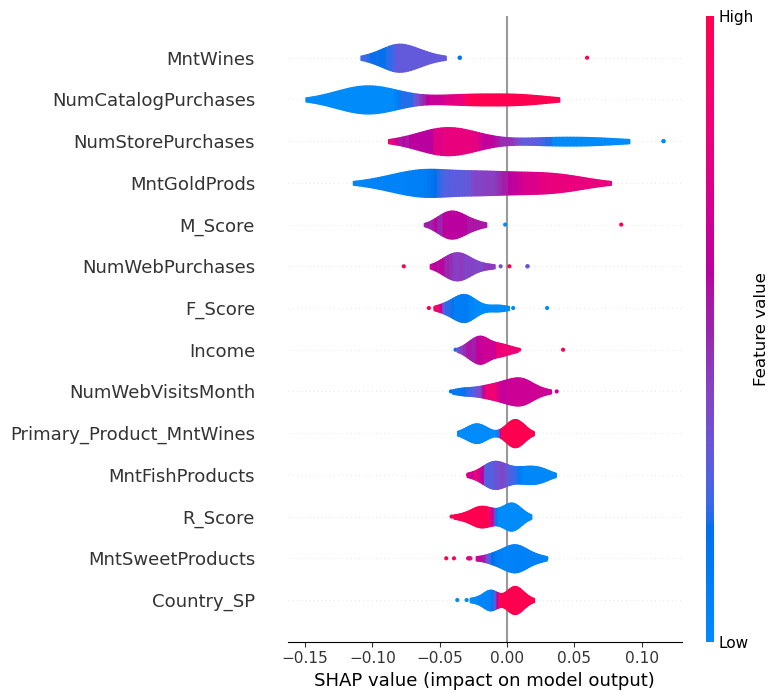

Showing SHAP summary for: Customer_Persona_Potential Loyalists with length of 131
Persona Shap shape: (131, 46)
X_transformed shape: (131, 46)


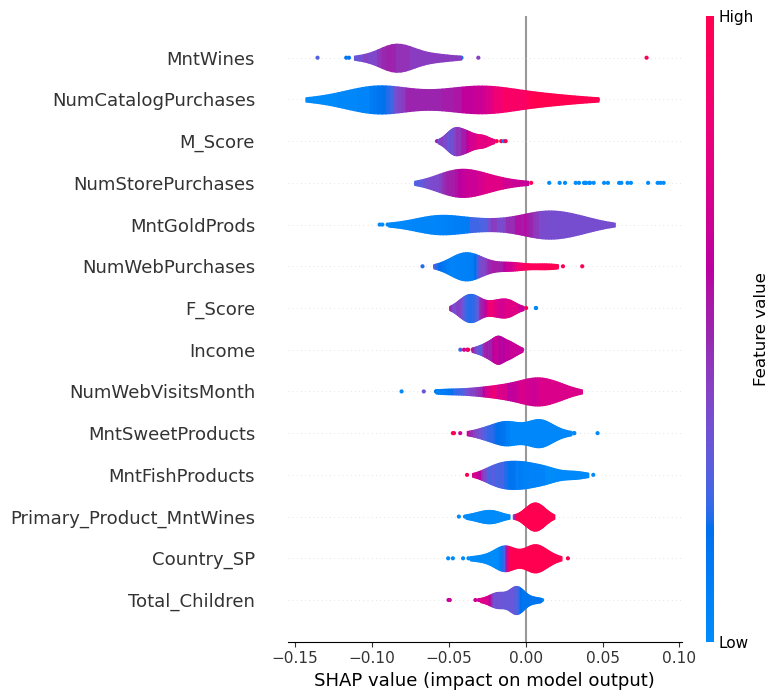

Showing SHAP summary for: Customer_Persona_At Risk with length of 108
Persona Shap shape: (108, 46)
X_transformed shape: (108, 46)


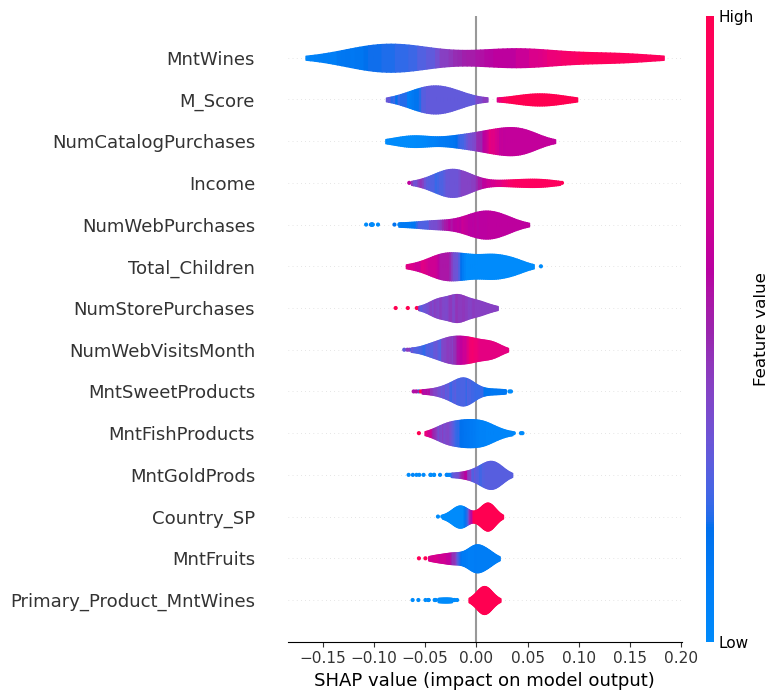

In [18]:
for i, (name, persona_shap) in enumerate(personas_shaps.items()):
    print(f"Showing SHAP summary for: {name} with length of {persona_shap['sample_count']}")
    print(f"Persona Shap shape: {persona_shap['shap_values'][:,:,1].shape}\nX_transformed shape: {persona_shap['X_transformed'].shape}")

    if hasattr(persona_shap['X_transformed'], 'toarray'):
        features_array = persona_shap['X_transformed'].toarray()
    else:
        features_array = np.array(persona_shap['X_transformed'])

    features_array = features_array.astype(np.float64)

    shap.summary_plot(
        persona_shap['shap_values'][:, :, 1],
        features=features_array,
        feature_names=persona_shap['X_transformed'].columns,
        plot_type='violin',
        max_display=14
    )

In [19]:
from shap_thresholds import find_positive_shap_thresholds

In [20]:
for persona in personas:
    find_positive_shap_thresholds(personas_shaps, persona=persona)


=== Top 10 Features for: Customer_Persona_Champions ===
• MntWines: SHAP > 0 at ~ 0.6391982325200716
• M_Score: SHAP > 0 at ~ 1.4142423268744673
• Income: SHAP > 0 at ~ 1.3266058071409752
• NumCatalogPurchases: SHAP > 0 at ~ 0.4427469505025876
• Total_Children: SHAP > 0 at ~ -1.2752627105461571
• NumWebPurchases: SHAP > 0 at ~ 0.32667713977165475
• NumStorePurchases: SHAP > 0 at ~ 0.3769523401167573
• R_Score: SHAP > 0 at ~ 0.7129555144471913
• MntFishProducts: SHAP > 0 at ~ -0.6839065666123846

=== Top 10 Features for: Customer_Persona_Loyal Customers ===
• MntWines: SHAP > 0 at ~ 0.9723729091808614
• NumCatalogPurchases: SHAP > 0 at ~ 0.4427469505025876
• Total_Children: SHAP > 0 at ~ -1.2752627105461571
• MntSweetProducts: SHAP > 0 at ~ -0.6475669537937865
• NumDealsPurchases: SHAP > 0 at ~ -1.1996616673725211
• Country_SP: SHAP > 0 at ~ 1.0226272978896154

=== Top 10 Features for: Customer_Persona_New Customers ===
• NumStorePurchases: SHAP > 0 at ~ -1.78031125791769
• MntGoldProd

The SHAP violin plots above demonstrate our model's feature importance at classifying whether a customer from a given customer segment will respond to our marketting strategies. There are some patterns that hold consistent from the general violin plot: the most important feature is the amount of wine products that a customer purchases. Some other features that are consistently within the top 5 most important features include the F score (Frequency), M score (Monetary/Total Spending), and the number of products bought through the catalog channel. Low/high values observed within a feature's distribution is encoded by color, while the x-axis represents the magnitude of impact that a feature has on impacting campaign success. Below are some strategies that we can implore to target certain customer segments for marketing outreach:

**At Risk**
- `MntWines`: Higher wine spending among *At Risk* customers signals engagement opportunities; customers that **spend more than $570 on wine** are more likely to respond to our marketing interventions. Despite their **At Risk** status, these high-value wine purchasers demonstrate strong brand affinity. This makes them ideal candidates for **targeted wine promotions** or **premium wine club offers**.

- `NumCatalogPurchases`: Mid to higher (>3) catalog purchase frequency indicates that traditional direct mail channels remain highly effective with this audience. We can consider increasing the catalog frequency and investment since this segment are proven responders. We can also test whether a more catalog-style digital format would be effective in other channels for customers that demonstrate similar engagement patterns. 

- `M_Score`: Customers that have an `M_Score` of 5 reveal an increase in receptivity to promotional communications; we should focus our marketing resources toward these higher spending customers rather than lower-spending customers for conversion opportunities.

**Potential Loyalists**
- `Primary_Product_MntGoldProds`: This customer segment provides an interesting dynamic because customers who primary / most bought product is **Gold Products** increases the likelihood of responding to marketing campaigns, however, the amount spent on these products do not display a clear relationship. As a result, we could choose to target these customers by maintaining the presence of gold products throughout all of the available channels. Preserving these product's placement in advertising will remind customers that gold products are sold at this store.

**New Customers**
- `NumStorePurchases`: Customers that aren't in-store buyers are more responsive to marketing campaigns; customers that have purchased goods less than 2 times indicate our target audience. This signifies that we should implore channels that aren't in person which is reinforced by the `Prefers_Web` feature.

- `MntGoldProds` and `Primary_Product_MntGoldProds`: Similar to potential loyalists, customers that primarily purchase **Gold Products** provide a clear correlation to campaign responsiveness, however, **New Customers** that purchases high (>$26) amounts of gold products also increase responsiveness in customers. Therefore, we can market gold products more towards these audiences and consider investing in more gold product advertising in Web channels.

- `Prefers_Web`: Customers that have a preference to use the web as their main channel tend to respond to marketing campaigns. As mentioned prior in the `NumStorePurchases` section, we should target users that have a preference to use the web for their purchases and aren't your frequent in-store buyers. 

In [21]:
# Choose a persona to analyze
target_persona = 'At Risk'

# Retrieve preprocessed data and SHAP values
persona_data = personas_shaps[target_persona]
shap_vals = persona_data['shap_values'][:,:,1]  # Class 1: positive response
X_transformed = persona_data['X_transformed']

# Get feature names post-transformation
feature_names = preprocessor.get_feature_names_out()
X_df = pd.DataFrame(X_transformed, columns=feature_names)

target_feature = 'remainder__MntWines'
shap.dependence_plot(
    feature_names.tolist().index('remainder__MntWines'), 
    shap_vals,
    X_df,
    interaction_index=None,  # You can also set this to explore interactions
    show=True
    )

KeyError: 'At Risk'